Multi Layer perceptron 

In [2]:
import math 
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class Value:
    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = _children
        self._op = _op
        self.label = label
    
    def __repr__(self) -> str:
        return f'Value(data = {self.data})'
    
    

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward

        return out
    
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    

    def __pow__(self, other):
        assert isinstance(other, (int,float)) # only support int & float powers for now
        out = Value(self.data**other, (self,), f'^{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    
    
    def __neg__(self):
        return -1 * self
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other
    
    def __rmul__(self, other):
        return self * other
    
    def __truediv__(self, other):
        return self * (other ** -1)
    
    def __rtruediv__(self, other):
        return self * (other ** -1)

    
    def sigmoid(self):
        x = self.data
        s = 1/(1+ math.exp(-x))
        out = Value(s, (self, ), 'sigmoid')

        def _backward():
            self.grad += s * (1-s)

        out._backward = _backward
        
        return out
    
    def relu(self):
        x = self.data
        r = max(x,0)
        out = Value(r, (self, ), 'ReLU')

        def _backward():
            self.grad += 1 if x > 0 else 0

        out._backward = _backward

        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def linear(self):
        x = self.data
        out = Value(x, (self, ), 'linear')

        def _backward():
            self.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def ln(self):
        x = self.data
        out = Value(math.log(x), (self, ), 'ln')

        def _backward():
            self.grad += (1/x) * out.grad
        out._backward = _backward
        return out
    

    def backward(self):
        topological = []
        visited = set()

        def build_topological(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topological(child)
                topological.append(v)

        build_topological(self)
        
        self.grad = 1.0
        for node in reversed(topological):
            node._backward()

In [4]:
class Neuron:
    
    def __init__(self, numIn, activation) -> None:
        self.w = [Value(random.uniform(-1,1)) for _ in range(numIn)]
        self.b = Value(random.uniform(-1,1))
        self.act_func = activation
    
    def __call__(self, x):
        # w . x + b
        act = sum(w1*x1 for w1, x1 in zip(self.w, x)) + self.b
        out = getattr(act, self.act_func)()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, numIn, numOut, activation) -> None:
        self.neurons = [Neuron(numIn, activation) for _ in range(numOut)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        params = []
        for neuron in self.neurons:
            params.extend(neuron.parameters())
        return params
    
        
class MLP:
    def __init__(self, numIn, numOuts, activations) -> None:
        sizes = [numIn] + numOuts 
        self.layers = [Layer(sizes[i], sizes[i+1], activations[i]) for i in range(len(numOuts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        params = []
        for layer in self.layers:
            params.extend(layer.parameters())
        return params
        

MNIST DATASET


In [5]:
import numpy as np

In [17]:
import pandas as pd
df = pd.read_csv('mnist_train.csv', header = 0)

y_train = df.iloc[:, 0].tolist()  # First column
X_train = df.iloc[:, 1:].values.tolist()  # Remaining columns


df_test = pd.read_csv('mnist_test.csv', header = 0)

y_train = df.iloc[:, 0].tolist()  # First column
X_train = df.iloc[:, 1:].values.tolist()  # Remaining columns

# xs -> 784-ary arrays 
# ys -> labels  

Initializing model...
Starting training...
Epoch 1, Step 0, Loss: 21.3060
Epoch 1 completed, Average Loss: 3.5718
Epoch 2, Step 0, Loss: 2.3218
Epoch 2 completed, Average Loss: 2.3250
Epoch 3, Step 0, Loss: 2.2950
Epoch 3 completed, Average Loss: 2.3053
Epoch 4, Step 0, Loss: 2.2865
Epoch 4 completed, Average Loss: 2.2988
Epoch 5, Step 0, Loss: 2.2839
Epoch 5 completed, Average Loss: 2.2966
Evaluating model...
Test accuracy: 0.0670


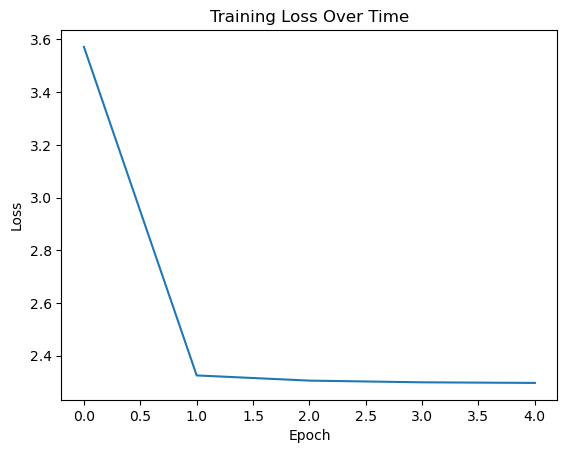

In [18]:
class MNISTClassifier:
    def __init__(self, layer_sizes=[784, 128, 64, 10]):
        """Initialize the MNIST classifier with specified layer sizes."""
        self.model = MLP(4, layer_sizes, ['linear','relu','relu','linear'])
        
    def forward(self, x):
        """Forward pass through the network."""
        # Convert input to list of Values
        x = [Value(xi) for xi in x]
        return self.model(x)
    
    def loss(self, outputs, target):
        """Calculate cross entropy loss."""
        # Simple negative log likelihood loss
        exp_scores = [o.exp() for o in outputs]
        sum_exp_scores = sum(exp_scores)
        probs = [e / sum_exp_scores for e in exp_scores]
        return -probs[target].ln()
    
    def train_step(self, x, y, learning_rate=0.01):
        """Perform one training step."""
        # Forward pass
        outputs = self.forward(x)
        
        # Calculate loss
        loss = self.loss(outputs, y)
        
        # Backward pass
        for p in self.model.parameters():
            p.grad = 0
        loss.backward()
        
        # Update weights
        for p in self.model.parameters():
            p.data -= learning_rate * p.grad
        
        return loss.data
    
    def predict(self, x):
        """Make prediction for input x."""
        outputs = self.forward(x)
        scores = [o.data for o in outputs]
        return np.argmax(scores)

def train_mnist(model, X_train, y_train, batch_size=32, epochs=5, learning_rate=0.01):
    """Train the model on MNIST data."""
    n_samples = len(X_train)
    losses = []
    
    for epoch in range(epochs):
        epoch_losses = []
        
        for i in range(0, n_samples, batch_size):
            batch_X = X_train[i:i + batch_size]
            batch_y = y_train[i:i + batch_size]
            
            batch_losses = []
            for x, y in zip(batch_X, batch_y):
                loss = model.train_step(x, y, learning_rate)
                batch_losses.append(loss)
            
            avg_loss = np.mean(batch_losses)
            epoch_losses.append(avg_loss)
            
            if i % 1000 == 0:
                print(f'Epoch {epoch+1}, Step {i}, Loss: {avg_loss:.4f}')
        
        avg_epoch_loss = np.mean(epoch_losses)
        losses.append(avg_epoch_loss)
        print(f'Epoch {epoch+1} completed, Average Loss: {avg_epoch_loss:.4f}')
    
    return losses

def evaluate(model, X_test, y_test, num_samples=1000):
    """Evaluate model accuracy on test set."""
    correct = 0
    for x, y in zip(X_test[:num_samples], y_test[:num_samples]):
        pred = model.predict(x)
        if pred == y:
            correct += 1
    
    accuracy = correct / num_samples
    return accuracy

def main():
    # # Load MNIST data
    # print("Loading MNIST dataset...")
    # (X_train, y_train), (X_test, y_test) = fetch_mnist()
    
    # Create and train model
    print("Initializing model...")
    model = MNISTClassifier([784, 128, 64, 10])
    
    print("Starting training...")
    losses = train_mnist(model, X_train, y_train, 
                        batch_size=32, 
                        epochs=5, 
                        learning_rate=0.01)
    
    # Evaluate model
    print("Evaluating model...")
    accuracy = evaluate(model, X_train, y_train)
    print(f"Test accuracy: {accuracy:.4f}")
    
    # Plot training loss
    plt.plot(losses)
    plt.title('Training Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()



if __name__ == "__main__":
    main()

In [9]:
# visualizing 

import matplotlib.pyplot as plt

def visualize_digit(pixel_list):

    # Ensure we have 784 elements
    if len(pixel_list) != 784:
        raise ValueError(f"Expected 784 elements, but got {len(pixel_list)}")
    
    # Convert the 1D list of 784 elements into a 2D list of 28x28
    image = []
    for i in range(0, 784, 28):
        row = pixel_list[i:i + 28]
        image.append(row)
    
    # Create figure and display
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.tight_layout()
    plt.show()


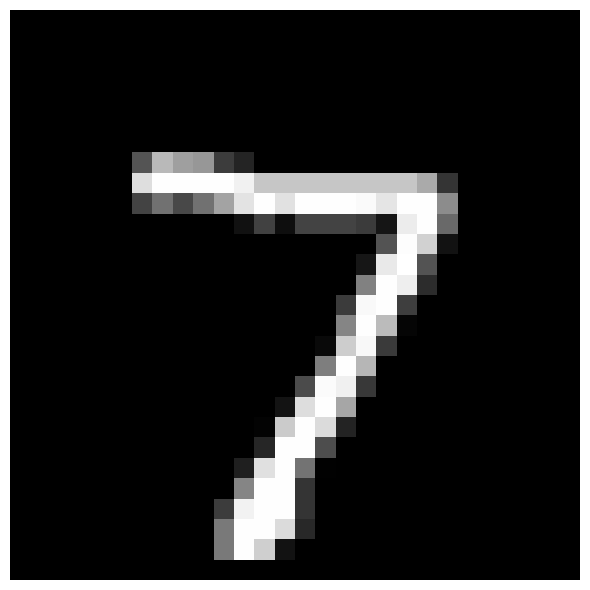

In [11]:
visualize_digit(X_train[0])

In [55]:
def one_hot_encode(labels, num_classes=10):
    encoded = []
    for label in labels:
        # Create a zero vector of length num_classes
        vector = [0] * num_classes
        # Set the corresponding index to 1
        vector[label] = 1
        encoded.append(vector)
    return encoded